In [1]:
import numpy as np
import json
import pprint
from matplotlib import pyplot as plt
from fileoperations.fileoperations import get_filenames_in_dir
from morty.pitchdistribution import PitchDistribution
from morty.converter import Converter

Below we are aggregating the tonic frequencies. For recordings, which have more than one annotation, we average the frequency.

Due to possible differences in annotation octave, directly taking the mean of frequencies would be erroneous. In addition, the octave information is ill-defined for recordings in which each instrument play the same melody in their own register. For these reasons, initially wrapped the annotation into a single octave (centered around the frequency of the first annotation as a dummy reference) and then take the mean.

If there is a change in tonic frequency over time in an audio recording, the time intervals are specified. This field if left empty, otherwise. We are ignoring recordings with variable tonic (there are very few cases).

In [19]:
tonic_json = json.load(open('annotations.json'))

tonic_array = []
for value in tonic_json.values():
    temp_time = [annot['time_interval'] for annot in value['annotations']]
    
    # Skip if there is an annotated time interval
    if not any(tt for tt in temp_time):
        temp_tonic = np.array([annot['value'] for annot in value['annotations']])
        
        # wrap the frequencies around the first annotation
        dummy_tonic = temp_tonic[0] # the first annotation
        temp_tonic = np.array([Converter.hz_to_cent(tt, dummy_tonic) for tt in temp_tonic])
        temp_tonic = np.mod(temp_tonic, 1200)  # Octave wrapped
        
        temp_tonic[temp_tonic>600] -= 1200  # center around the first annotation
        temp_mean = np.mean(temp_tonic)
        tonic_array.append(Converter.cent_to_hz(temp_mean, dummy_tonic))

Below we compute the distribution of pitches. We use [the PitchDistribution class from morty] (https://github.com/altugkarakurt/morty/blob/master/morty/pitchdistribution.py)]

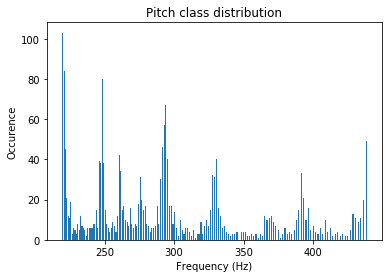

In [17]:
tonic_dist = PitchDistribution.from_hz_pitch(tonic_array, kernel_width=0, 
                                             ref_freq=220.0, norm_type=None)
tonic_dist.to_pcd()
tonic_dist.cent_to_hz()
tonic_dist.bar()
plt.axis('tight')
plt.show()